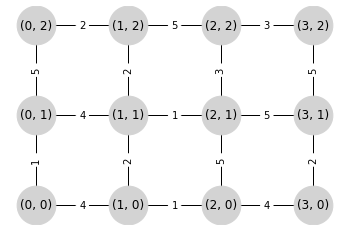

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

np.random.seed(1000)

G = nx.grid_2d_graph(4,3)
for (u,v) in G.edges():
  G[u][v]['weight'] = np.random.randint(1,6)

nx.draw_networkx(G, pos={v:v for v in G.nodes()},
    node_color='lightgrey', node_size=1500, width=1)
nx.draw_networkx_edge_labels(G,
    edge_labels={(u,v):G[u][v]['weight'] for (u,v) in G.edges()},
    pos={v:v for v in G.nodes()})
plt.axis('off')
plt.show()

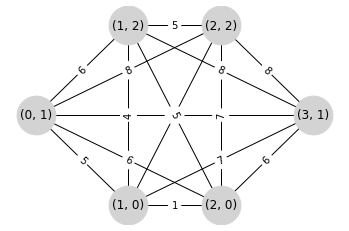

In [3]:
from itertools import combinations

Vodd = [v for v in G.nodes() if G.degree(v)%2 == 1]
dist = dict(nx.all_pairs_dijkstra_path_length(G))

K = nx.Graph()
K.add_weighted_edges_from([(u,v,dist[u][v])
                          for (u,v) in combinations(Vodd,2)])
nx.draw_networkx(K,pos={v:v for v in K.nodes()},
    node_color='lightgrey', node_size=1500, width=1)
nx.draw_networkx_edge_labels(K,pos={v:v for v in K.nodes()},
    edge_labels={(u,v):K[u][v]['weight'] for (u,v) in K.edges()})
plt.axis('off')
plt.show()

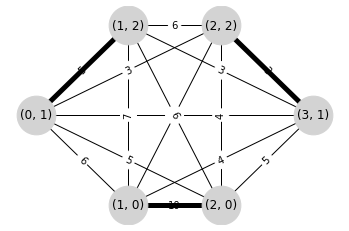

In [4]:
CK = K.copy()
wm = max(CK[u][v]['weight'] for (u,v) in CK.edges())
for (u,v) in K.edges():
  CK[u][v]['weight'] = wm - CK[u][v]['weight']+1
m = nx.max_weight_matching(CK, maxcardinality=True)
md = dict(m)
mm = []
for (u,v) in md.items():
  if(u,v) not in mm and (v,u) not in mm:
    mm.append((u,v))

nx.draw_networkx(CK, pos={v:v for v in CK.nodes()},
    node_color='lightgrey', node_size=1500, width=1)
nx.draw_networkx_edge_labels(CK, pos={v:v for v in CK.nodes()},
    edge_labels={(u,v):CK[u][v]['weight'] for (u,v) in CK.edges()})
nx.draw_networkx_edges(CK, pos={v:v for v in CK.nodes()}, edgelist=mm, width=5)
plt.axis('off')
plt.show()

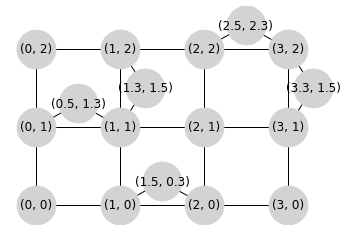

In [8]:
CG = G.copy()
for (u,v) in mm:
  dp = nx.dijkstra_path(G,u,v)
  for i in range(len(dp)-1):
    (ux,uy) = dp[i]
    (vx,vy) = dp[i+1]
    if ux == vx:
      wx = ux+0.3
      wy = (uy+vy)/2.0
    else:
      wx = (ux+vx)/2.0
      wy = uy+0.3
    CG.add_edges_from([((ux,uy), (wx,wy)), ((wx,wy), (vx,vy))])
nx.draw_networkx(CG, pos={v:v for v in CG.nodes()},
     node_color='lightgrey', node_size=1500, width=1)
plt.axis('off')
plt.show()

In [9]:
ec = nx.eulerian_circuit(CG)
for (i,j) in ec:
  print(i, end='->')

(0, 0)->(0, 1)->(0.5, 1.3)->(1, 1)->(1.3, 1.5)->(1, 2)->(2, 2)->(2.5, 2.3)->(3, 2)->(3.3, 1.5)->(3, 1)->(3, 2)->(2, 2)->(2, 1)->(2, 0)->(1.5, 0.3)->(1, 0)->(1, 1)->(1, 2)->(0, 2)->(0, 1)->(1, 1)->(2, 1)->(3, 1)->(3, 0)->(2, 0)->(1, 0)->

In [10]:
from pulp import *
from itertools import product
MEPS = 1.0e-10

In [22]:
def TSPSolveSubtourElim(G,x,y):
  n = len(G.nodes())
  nodes = list(G.nodes())
  edges = [(nodes[i],nodes[j]) for (i,j) in product(range(n),range(n))
           if nodes[i] < nodes[j]]
  D = np.sqrt((x.reshape(-1,1)-x)**2 + (y.reshape(-1,1)-y)**2)

  prob = LpProblem('TSP',LpMinimize)

  x = {(u,v): LpVariable('x'+str(u)+","+str(v),
       lowBound=0, cat='Binary') for (u,v) in edges}
  prob += lpSum(D[i,j]*x[i,j] for (i,j) in edges)
  for i in nodes:
    ss = [(j,i) for j in nodes if (j,i) in edges]+[(i,j) for j in nodes if (i,j) in edges]
    prob += lpSum(x[e] for e in ss) == 2, 'Eq'+str(i)
  
  prob.solve()
  subtours = []
  for (i,j) in edges:
    if x[i,j].varValue > MEPS:
      subtours.append([i,j])
  G.add_edges_from(subtours)

  CC = list(nx.connected_components(G))
  while len(CC) > 1:
    for S in CC:
      prob += lpSum(x[i,j] for (i,j) in edges
                    if i in S and j in S) <= len(S)-1
    prob.solve()

    G.remove_edges_from(subtours)
    subtours = []
    for (i,j) in edges:
      if x[i,j].varValue > MEPS:
        subtours.append([i,j])
    G.add_edges_from(subtours)
    CC = list(nx.connected_components(G))
  
  len_tour = 0
  for(u,v) in G.edges():
    len_tour += D[u,v]
  
  return len_tour

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sasa./miniforge3/envs/py38/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/f1/dg38sdvs7tsgxf3hbspgk1vc0000gn/T/44f15b7787f1401ea1bf5f73a558c0a7-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/f1/dg38sdvs7tsgxf3hbspgk1vc0000gn/T/44f15b7787f1401ea1bf5f73a558c0a7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 105 COLUMNS
At line 24856 RHS
At line 24957 BOUNDS
At line 29908 ENDATA
Problem MODEL has 100 rows, 4950 columns and 9900 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 7548.16 - 0.00 seconds
Cgl0004I processed model has 100 rows, 4950 columns (4950 integer (4950 of which binary)) and 9900 elements
Cbc0038I Initial state - 6 integers unsatisfied sum - 3
Cbc0038I Pass   1: suminf.    3.00000 (6) obj. 9158.73 iterations 142


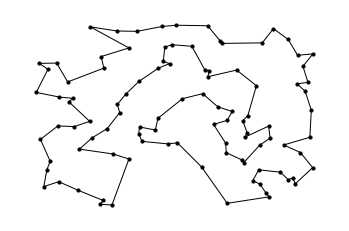

In [25]:
n =100
vlist = [i for i in range(n)]
Tours = nx.Graph()
Tours.add_nodes_from(vlist)

np.random.seed(1234)
x = np.random.randint(low=0, high=1000, size=n)
y = np.random.randint(low=0, high=1000, size=n)
p = {i: (x[i],y[i]) for i in range(n)}

TSPSolveSubtourElim(Tours, x, y)
nx.draw_networkx(Tours, pos=p, node_color='k', node_size=10, with_labels=False)
plt.axis('off')
plt.show()